# Tutorial Delft3D FM 1D2D fluvial flood model of Magdalena river 

This notebook is an introduction on how-to use [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) functionalities to create/adjust a Delft3D FM Suite 1D2D fluvial flood model of the Magdalena river in Columbia. First an 1D river model of the Magdalena river and Canal del Dique will be created, shown in the left figure. This model will be extended with an 2D Flexible Mesh, whereafter a MERIT DTM will be added to the model in order to mimic the fluvial flood patterns. Running the model or importing the model in the Delft3D FM Suite 1D2D is not part of the exercise.  

<p align="center">
  <img alt="Light" src="figures/1D_model.png" width="45%" >
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Dark" src="figures/1D2D_model.png" width="45%">
</p>

Note that the model and tutorial are created for educational purposes and consist partially of fictive/unvalidated model data. 

<hr style="border-style: dotted;" />

 ```HYDROLIB-core``` is the core library of Python wrappers around the D-HYDRO Suite 1D2D model files (input and output) and model engines (kernel libraries). ```HYDROLIB``` is a Python package with tools for pre-processing, post-processing and analysis of hydrodynamical data and simulation results, currently focused on Delft3D Suite 1D2D. [HYDROLIB](https://github.com/Deltares/HYDROLIB)  builds upon the basic HYDROLIB-core functionalities.

<hr style="border-style: dotted;" />

As mentioned above, the goal of this tutorial is to familiarize modelers with how to apply HYDROLIB-core functionalities in their modelling procedures such as fluvial flood modelling.  This is done by the following steps

1. Loading libraries
1. Connect to data
1. Create empty D-Flow FM model 
3. Read branches
4. Create computational grid
5. Add cross-sections
6. Add roughness
7. Add initial conditions
8. Add a weir to the model
9. Save 1D model
10. Create 2D flexible mesh
11. Add 2D DTM to model
12. Generate 1D2D links
13. Save 1D2D model

### Installation
To run this notebook a simple Python environment with the following packages is required:
```
TO DO 
```
_Remark_ Note that an email was sent to all participants to download the material from download portal and to create an environment with the ```hydrolib-core``` package installed from ```environment.yaml```. Furthermore, a dummy model was provided at the download portal to test the [Conda](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#) environment.

### Jupyter Notebook shortcuts
Still need to be added

Let's get started

## Loading libraries
__EX1__: Import the libraries required in the notebook below. _Tip: please consult the [HYDROLIB-core documentation](https://deltares.github.io/HYDROLIB-core/0.3.1/)_

In [11]:
# basis 
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt


# I/O
from pathlib import Path

# Answer to 1 -  hydrolib-core libraries. Note in future releases io should be followed by .dflowfm
from hydrolib.core.io.mdu.models import FMModel
from hydrolib.core.io.net.models import *
from hydrolib.core.io.crosssection.models import CrossLocModel, CrossDefModel, CrossSection



## Connect to data
__EX2__:

In [2]:
# Answer EX2

# Specify paths to connect to local zip
root = Path.cwd()
inputdir = root / 'data'

# Download data from zip
# TODO: download from HYDROLIB-data

## Create empty D-Flow FM model

In [3]:
# Answer EX3

# Create empty D-Flow FM model
fm = FMModel()

# Assign filepath to the D-Flow FM model
outputdir = root / '1D_model'
fm.filepath = outputdir / 'Magdalena_1D.mdu'

## Read branches


In [4]:
# Read the branches
branches = gpd.read_file(filename = inputdir / 'branches_Branches.shp')


## Create computational grid


In [5]:
dx = 1000.0
network = Network()

for index,branch in branches.iterrows():
    xy = np.transpose(branch.geometry.xy)
    branch_new = Branch(geometry=xy)
    branch_new.generate_nodes(mesh1d_edge_length=dx)
    network.mesh1d_add_branch(branch_new, name=branch.Name)

fm.geometry.netfile.network = network
fm.geometry.netfile.filepath = "FlowFM_net.nc"


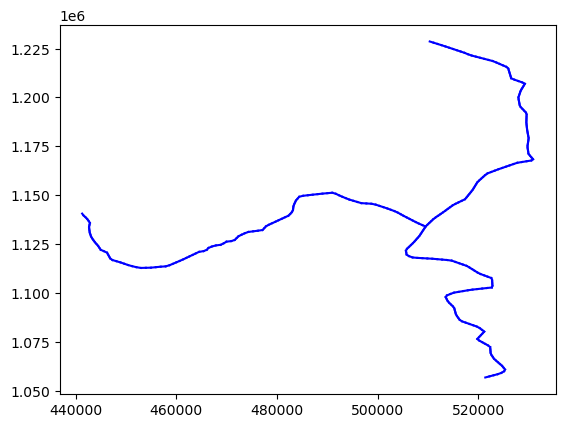

In [7]:
figure, ax = plt.subplots()
network._mesh1d._set_mesh1d()
mesh1d_meshkernel = network._mesh1d._get_mesh1d()
mesh1d_meshkernel.plot_edges(ax=ax, color='blue')

## Add cross-sections


In [10]:
profiles_file = inputdir / '1D_YZ_CrossSections.xlsx'

profiles = pd.read_excel(profiles_file, sheet_name=None)

prof_names = list(profiles.keys())

chainages = [1000.0, 95000.0, 1000.0, 95000.0, 1000.0, 113000.0]
branches_names = [branches.Name[0],branches.Name[0],branches.Name[1],branches.Name[1],branches.Name[2],branches.Name[2]]

# create cross-section locations
crsloc = CrossLocModel()

for index,prof_name in enumerate(prof_names):
    crs = CrossSection()
    crs.
    crsloc.crosssection()


## Add roughness


## Add initial conditions


## Add a weir to the model


## Save 1D model


In [ ]:
# Save the 1D model. 
fm.save(recurse=True)

## Create 2D flexible mesh


## Add DTM to 2D model


## Generate 1D2D links


## Save 1D2D model